<a href="https://colab.research.google.com/github/fersondahl/Route_Optimization/blob/main/Framework_TSP_RJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Otimização Trajeto - RJ**
### Aplicação do modelo *TSP*
###### Autor: Fernando Söndahl Brito

 ##  **1. Contexto**

> O objetivo desse trabalho é gerar um modelo de otimização para o caso *TSP*. Como base, foram utilizadas as coordenadas dos municípios do estado do Rio de Janeiro e tendo como produto a rota que minimiza as distâncias euclidianas do percurso.

### Motivação

<img src="https://github.com/fersondahl/roterizacao/blob/main/Motiva%C3%A7%C3%A3o.png?raw=true" alt="drawing" width="800"/>


##  **2. Pacotes e bibliotecas**

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils
!pip install haversine

In [2]:
import time
import os
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine, Unit, haversine_vector
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import geopandas

import shapely
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon


## **3. Dados do problema**
> Coleta das coordenadas e tabela De Para com o cálculo combinatótio das distâncias entre os nós (municípios).

In [3]:
rj = geopandas.read_file(r"https://github.com/fersondahl/Route_Optimization/raw/main/Camada%20RJ.GEOJSON")[["NOME", "geometry"]]

rj['ponto_representativo'] = rj['geometry'].apply(lambda linha: linha.representative_point())
rj['Longitude'] = rj['ponto_representativo'].apply(lambda linha: linha.coords[0][0])
rj['Latitude'] = rj['ponto_representativo'].apply(lambda linha: linha.coords[0][1])

dic_comb = {'origem': [], 'destino': [], 'loc_orig': [], 'loc_dest': []}

geo_df = rj.copy()
geo_df['cords'] = geo_df['Latitude'].astype(str) + ", " + geo_df['Longitude'].astype(str)
geo_df['chave'] = geo_df.index

#### dist - DataFrame de combinação de todas as distâncias das coordenadas entre si

comb = [
    itertools.product(*[geo_df['chave'], geo_df['chave']]),
    itertools.product(*[geo_df['cords'], geo_df['cords']])
  ]

dist_df = pd.concat(list(map(lambda elem: pd.DataFrame(elem), comb)), axis=1)

dist_df.columns = ['origem', 'destino', 'loc_orig', 'loc_dest']

for col in['loc_orig', 'loc_dest']:
  dist_df[col] = dist_df[col].apply(lambda lin: tuple((list(map(float, lin.split(','))))))

dist_df['Distancia'] = haversine_vector(list(dist_df['loc_orig']), list(dist_df['loc_dest'])).astype(float)


matriz_de_para = dist_df.pivot(values='Distancia', index='origem', columns='destino')

## **4. Modelo de Otimização**
> Modelagem do problema a partir de programação linear inteira. Foi utilizada a formulação DFJ para inibir o sub-roteamento e adotou-se o método de *lazy constraints* para a não explosão exponencial do problema.
A cada iteração, são verificadas as sub-rotas contidas na solução e são adicionadas restrições para impedi-las. As iterações findam quando a solução  encontra apenas um ciclo ligando todos os nós.

### a) Instanciação do Modelo Clássico

*max* $\sum_{j=1}^{n}$ $\sum_{i=1}^{n}$ $x_{ij}$ * $d_{ij}$

*St.*

$\sum_{i=1}^{n}$ $x_{ij}$ = 1, ∀ j | j ≠ i

$\sum_{j=1}^{n}$ $x_{ij}$ = 1, ∀ i | j ≠ i

0 ≤ $x_{ij}$ ≤ 1, $x_{ij}$ ∈ ℤ

Sendo:

$x_{ij}$: Variável binária que assumirá 1 se o trajeto entre as cidades *i* e *j* for percorrido, e 0 caso contrário.

$d_{ij}$: A distância entre as cidades *i* e *j*.

In [4]:
# Instanciação do modelo e solução inicial

model = pyo.ConcreteModel()


model.vertice = pyo.Var(range(len(matriz_de_para)), range(len(matriz_de_para)), bounds=(0, 1), within=Integers)
vertice = model.vertice


model.C1 = pyo.ConstraintList()
for i in range(len(matriz_de_para)):
    model.C1.add(expr= sum(vertice[i, j] for j in range(len(matriz_de_para))) == 1)  # Restrição [2]
    model.C1.add(expr= sum(vertice[j, i] for j in range(len(matriz_de_para))) == 1) # Restrição [3]

model.C2 = pyo.ConstraintList()
for i in range(len(matriz_de_para)):
    model.C2.add(expr= vertice[i, i] ==0)    #Imperdir nó de sair e chegar em si próprio

model.restS = pyo.ConstraintList()

model.obj = pyo.Objective(expr= sum(vertice[i, j]*matriz_de_para[i][j] for i in range(
                                len(geo_df)) for j in range(len(geo_df))), sense=minimize) # Restrição [6]

opt = SolverFactory('glpk', executable='/usr/bin/glpsol')
opt.solve(model)

result = []
resultado = []

vet_mult = list(range(len(matriz_de_para)))
for i in range(len(matriz_de_para)):
    resultado.append(int(sum(pyo.value(vertice[i,j])*vet_mult[j] for j in range(len(matriz_de_para)))))

geo_df['Destino_inic'] = resultado


### b) Solução Iterativa + Restrição *DFJ*


*St.*

$\sum_{i ∈ K}$$\sum_{j≠i, j ϵ K}$ $x_{ij}$ ≤ |*K*| - 1, ∀ *K* ⊊ {1, ... , n}, |*K*| ≥ 2

In [6]:
# Solução iterativa do modelo - contenção dos subciclos
ciclo = []
subrotas = []
subciclo = []

durac = time.time()

n_iter = 1
model.restS.clear()
while len(ciclo) != len(geo_df):

    for s in subciclo:
        model.restS.add(expr =sum(vertice[i, j] for i in s for j in s) - len(s) <=  -1)

    print(f"{n_iter}ª iteração: {len(model.restS)} restrições DFJ.")

    opt = SolverFactory('glpk', executable='/usr/bin/glpsol')
    opt.solve(model)

    result = []
    resultado = []

    vet_mult = list(range(len(matriz_de_para)))
    for i in range(len(matriz_de_para)):
        resultado.append(int(sum(pyo.value(vertice[i,j])*vet_mult[j] for j in range(len(matriz_de_para)))))

    geo_df['Destino'] = resultado

    ciclo = [geo_df['chave'][0]]
    subrotas = []
    arestas = []
    j=0

    control = ''

    while control != 'done':

        for i in range(len(geo_df)):
            ciclo.append(geo_df['Destino'][j])
            arestas.append(geo_df['Destino'][j])
            j=geo_df['Destino'][j]

        ciclo = list(dict.fromkeys(ciclo))

        subrotas.append(ciclo)
        arest_tot = sum(list(map(lambda elemento: len(elemento), subrotas)))
        dif = list(set(arestas).symmetric_difference(set(list(geo_df['chave']))))
        try:
            j = dif[0]
            ciclo = [dif[0]]
        except IndexError:
            control = 'done'

    subciclo +=subrotas

    n_iter +=1


print(f'Otimização concluída em {round(time.time() - durac, 2)} segundos\nDistância total: {round(pyo.value(model.obj), 2)}')


1ª iteração: 0 restrições DFJ.
2ª iteração: 42 restrições DFJ.
3ª iteração: 98 restrições DFJ.
4ª iteração: 160 restrições DFJ.
5ª iteração: 230 restrições DFJ.
6ª iteração: 303 restrições DFJ.
7ª iteração: 380 restrições DFJ.
8ª iteração: 461 restrições DFJ.
9ª iteração: 544 restrições DFJ.
Otimização concluída em 22.07 segundos
Distância total: 1823.44


## **5. Resultado**



### a) Impacto do *Lazy Constraint*:

>O total de restrições *DFJ* necessárias para evitar todos os sub-ciclos é dada pela expressão: $2^n- n-2$.

>No caso dos municípios do Rio de Janeiro $n = 92$, o que define $4,95 * 10^{27}$ restrições.


In [ ]:
print(f"A utlização da técnica Lazy Constraint permitiu a solução do problema com apenas {len(model.restS)} restrições DFJ,\ngarantindo uma modelagem de acordo com os limites computacionais.")

A utlização da técnica Lazy Constraint permitiu a solução do problema com apenas 544 restrições DFJ,
garantindo uma modelagem de acordo com os limites computacionais.


### b) Soluções obtidas:

In [ ]:
#### mapa dos trajetos
def plots(soluc: str, title: str):

  trajetos_df = geo_df[['chave', 'Latitude', 'Longitude', soluc]].rename(
    columns={'chave': 'Origem'})

  trajetos_df = pd.merge(left=trajetos_df, right=geo_df[['Longitude', 'Latitude']], left_on=soluc, right_index=True, how='left')

  trajetos_df['geometry'] = list(map(lambda lng_x, lat_x, lng_y, lat_y: LineString([Point(lng_x, lat_x), Point(lng_y, lat_y)]),
          trajetos_df['Longitude_x'], trajetos_df['Latitude_x'], trajetos_df['Longitude_y'], trajetos_df['Latitude_y']
         ))

  with sns.axes_style('dark'):
      # Plotagem do mapa

      fig, ax = plt.subplots()
      # Layer RJ
      rj.plot(ax=ax, alpha=0.8,color='slategrey')
      # Coordenadas dos serviços
      plt.plot(list(geo_df['Longitude']), list(geo_df['Latitude']), 'ko')

      # Trajetos
      geopandas.GeoDataFrame(trajetos_df).plot(linewidth = 2, linestyle = "-", color='chocolate', ax=ax)

      plt.title(title, fontdict={'fontsize': 20, 'horizontalalignment': 'center','verticalalignment': 'bottom'})
      plt.xticks(ticks=[])
      plt.yticks(ticks=[])

      fig.set_figheight(10, forward=True)
      fig.set_figwidth(15, forward=True)

> O Resultado da primeira iteração é a aplicação do modelo clássico sem a formulação *DFJ*, o que resulta em uma solução inviável pela formação de sub-ciclos.

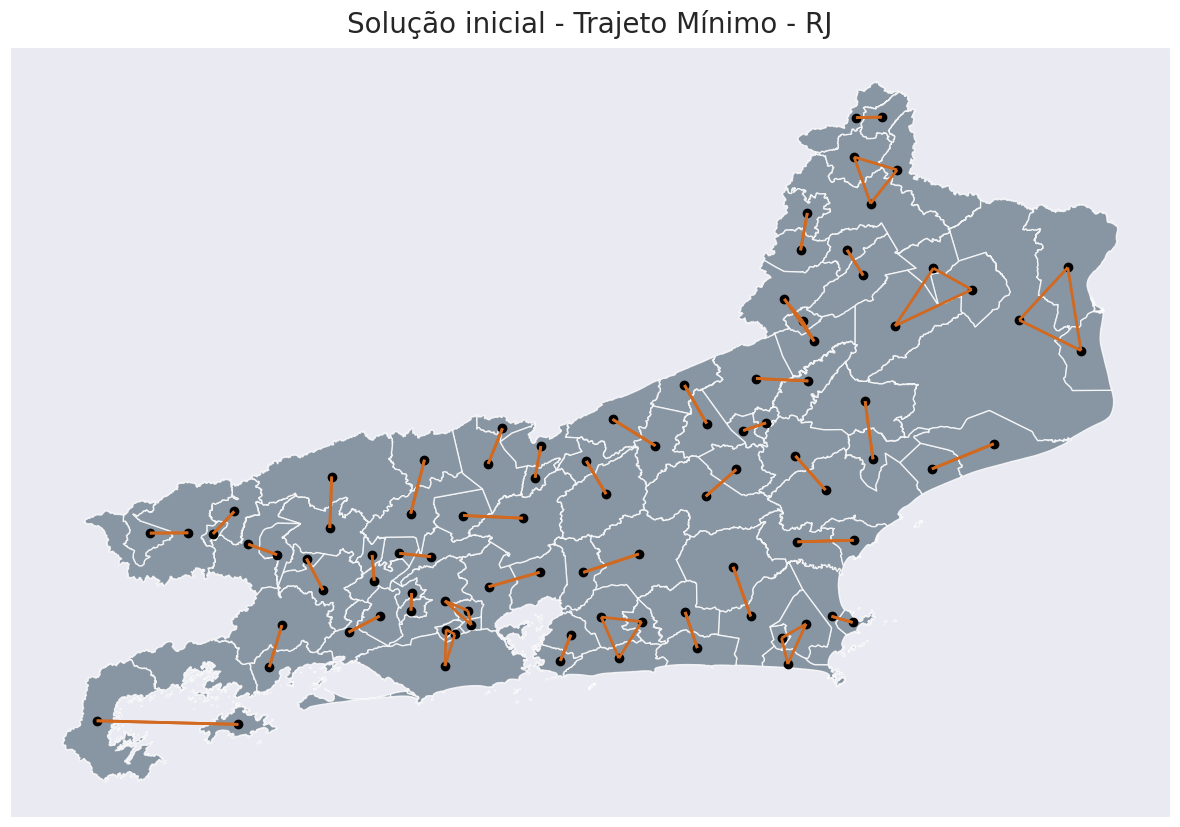

In [ ]:
plots("Destino_inic", "Solução inicial - Trajeto Mínimo - RJ")

> A implementação da formulação restringe a formação dos sub-ciclos, até que se chegue na solução viável ótima.

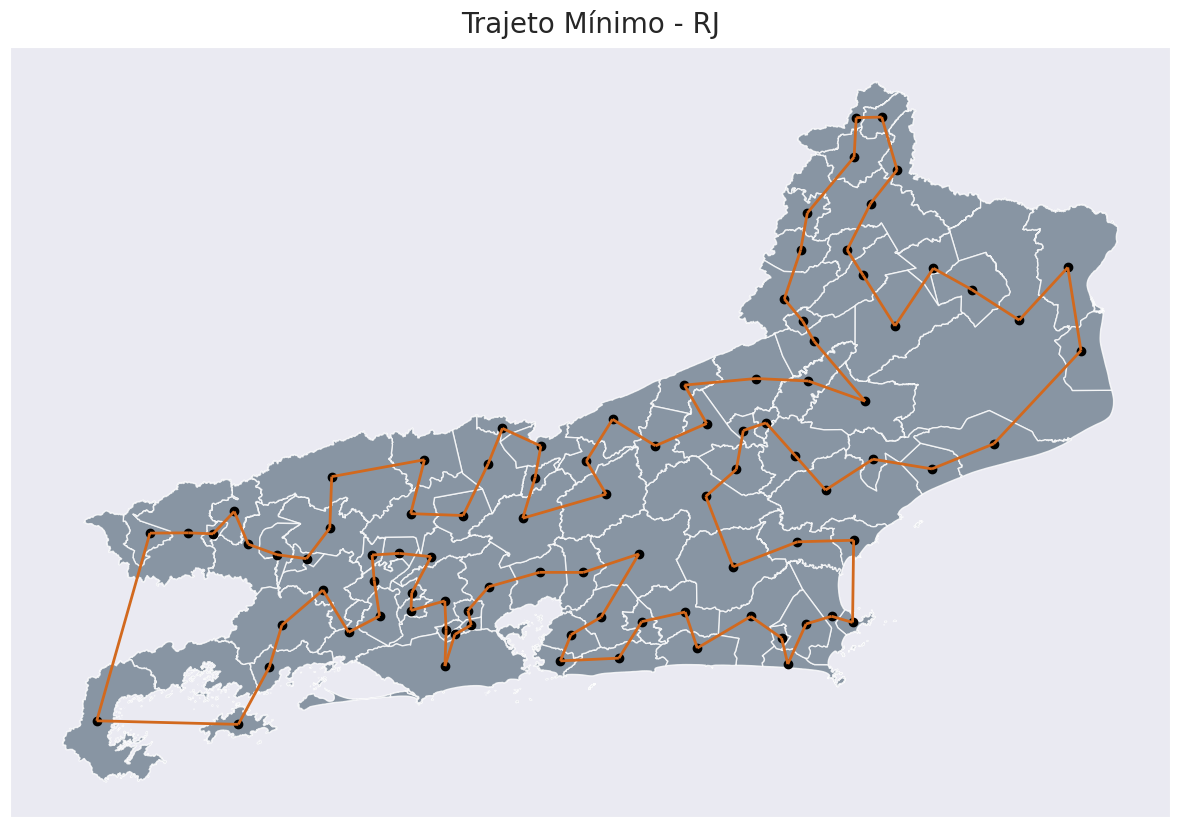

In [ ]:
plots("Destino", "Trajeto Mínimo - RJ")